In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/home/tignjatov/anaconda3/envs/ml/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
CHANNELS_IMG = 1
IMG_SIZE = 32
BATCH_SIZE = 128
EPOCHS = 40

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [6]:
trainset = torchvision.datasets.MNIST(root='../mnist_datasets/data/',
                                       train = True,
                                       download = True,
                                       transform = transform)
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)

In [7]:
testset = torchvision.datasets.MNIST(root='../mnist_datasets/data/',
                                       train = False,
                                       download = True,
                                       transform = transform)
testloader = DataLoader(testset,batch_size = BATCH_SIZE,shuffle = True)

In [8]:
class ConvNet(nn.Module):
   def __init__(self,no_classes):
      super().__init__()
      self.conv1 = nn.Conv2d(1,6,5)
      self.pool = nn.MaxPool2d(2,2)
      self.conv2 = nn.Conv2d(6,16,5)
      self.fc1 = nn.Linear(400,120)
      self.fc2 = nn.Linear(120,84)
      self.fc3 = nn.Linear(84,no_classes)
    
   def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
net = ConvNet(len(trainset.classes))
net.to(device)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters())

In [11]:
train_loses = []
test_losses = []
acc_list = []

for epoch in tqdm.tqdm(range(EPOCHS)):
  train_loss = 0
  test_loss = 0
  net.train()
  for img,lab in trainloader:
    #print(img.shape)
    img = img.to(device)
    lab = lab.to(device)

    optimizer.zero_grad()

    outputs = net(img)
    loss = criterion(outputs,lab)

    train_loss += loss.item()


    loss.backward()
    optimizer.step()
  #print(f'Epoch {epoch+1} with train loss {train_loss}\n')
  train_loses.append(train_loss)

  net.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for img,lab in testloader:
      img = img.to(device)
      lab = lab.to(device)
      
      outputs = net(img)
      loss = criterion(outputs,lab)
      _ , preds = torch.max(outputs,1)
      total += lab.size(0)
      correct += (preds == lab).sum().item()

      test_loss += loss.item()
  test_losses.append(test_loss)
  #print(f'Epoch {epoch+1} with test loss {test_loss}\n')
  acc_list.append(100 * correct/total)
  print(f'Epoch {epoch+1} with test accuracy {100*correct/total}%\n')
    

100%|██████████| 40/40 [09:07<00:00, 13.68s/it]


In [12]:
net.eval()
pred_list  = []
lab_list = []
with torch.no_grad():
    for img,lab in tqdm.tqdm(testloader):
          img = img.to(device)
          lab = lab.to(device)
          
          outputs = net(img)
          loss = criterion(outputs,lab)
          _ , preds = torch.max(outputs,1)
          pred_list += preds.cpu().numpy().tolist()
          lab_list += lab.cpu().numpy().tolist()
          total += lab.size(0)
          correct += (preds == lab).sum().item()


100%|██████████| 79/79 [00:01<00:00, 42.08it/s]


In [22]:
torch.save(net.state_dict(), './model/40_epochs_adam_mnist_classifier.pt')

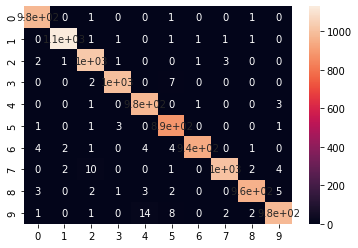

In [14]:
sns.heatmap(confusion_matrix(lab_list,pred_list),annot=True)
plt.show()

In [20]:
from sklearn.metrics import f1_score

print(f1_score(lab_list,pred_list,average='macro'))

0.9882782260758207


In [16]:
print(classification_report(lab_list,pred_list))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



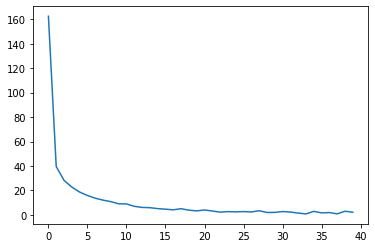

In [19]:
plt.plot(range(EPOCHS),train_loses,label = 'Train Loss')
#plt.plot(range(EPOCHS),test_losses,label = 'Test Loss')
plt.show()

In [ ]:
def clasify_img(img,net,transform,device):
    net.eval()
    image_3_tensor = transform(img[:,:,:1])
    image_3_tensor= image_3_tensor.to(device)
    output = net(image_3_tensor.unsqueeze(1))
    _, pred = torch.max(output, 1)
    return pred

In [ ]:
# net_loaded = ConvNet(len(trainset.classes))
# net_loaded.load_state_dict(torch.load('./model/64epochs_mnist_classifier.pt'))

<All keys matched successfully>

In [ ]:
# net_loaded.to(device)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# image_1 = plt.imread('test_image.png')
# image_3 = plt.imread('test_image_3.png')

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((28,28))
# ]
# )

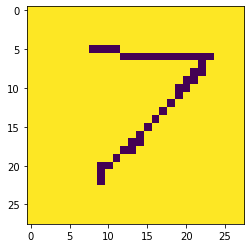

In [ ]:
# plt.imshow(image_1[:,:,:1])
# plt.show()

In [ ]:
# trainset.classes[clasify_img(image_1,net_loaded,transform,device)]

'8 - eight'

In [ ]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
output = net(img.to(device))

In [ ]:
_ , pred = torch.max(output, 1)

In [ ]:
pred

tensor([9, 0, 9, 2, 7, 1, 4, 2, 5, 3, 3, 6, 5, 1, 3, 7, 0, 2, 1, 3, 9, 7, 1, 9,
        8, 4, 4, 7, 0, 1, 5, 5], device='cuda:0')

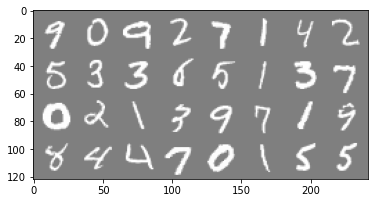

In [ ]:
imshow(torchvision.utils.make_grid(img))